# AEを実装
* VAEとの比較をしたい
* スパース正則化を入れないAE

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
import six

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence

import matplotlib.pyplot as plt

# chainer exampleに付属のdata.pyをimportする. mnistのダウンロードのため
import data


## GPU設定

In [2]:
gpu_flag = 0
if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np

## MNISTデータのセット

In [3]:
mnist = data.load_mnist_data()

In [4]:
# 複数の画像配列になっているdata列を描画する
def draw_digit(data):
    size = 28
    n = data.shape[0]
    plt.figure(figsize=(n, 2))
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]             # flip vertical
        plt.xlim(0,27)
        plt.ylim(0,27)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()

# いくつかランダムにプロット
def draw_digit_multi(data, n=10):
    # サンプラー
    indexes = np.random.permutation( len(data) )[:n]
    # 
    size = 28
    plt.figure(figsize=(15, 2))
    # plot
    cnt = 1
    for idx in indexes:
        plt.subplot(1, n, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]
        plt.xlim(0, size-1)
        plt.ylim(0, size-1)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
    return indexes

In [5]:
#idxs = draw_digit_multi(mnist['data'])
#print "labels : "
#print mnist['target'][idxs]

In [6]:
# 正規化
mnist['data'] = mnist['data'].astype(np.float32)
mnist['data'] /= 255
mnist['target'] = mnist['target'].astype(np.int32)
# 訓練データとテストデータに分割
N = 60000
x_train, x_test = np.split(mnist['data'],   [N])
y_train, y_test = np.split(mnist['target'], [N])
N_test = y_test.size

## パラメータ設定

In [8]:
batchsize = 100 # ミニバッチのサイズ
n_epoch = 20     # epoch数
n_latent = 100   # 潜在変数の次元(DCGANで言うところのプライヤーベクトルの次元)
n_h = 500 # エンコーダー、デコーダーの隠れ層のノード数

# Optimizer
al = 0.001
b1 = 0.9
b2 = 0.999

## モデル定義

In [9]:
class AE(chainer.Chain):
    """AutoEncoder"""
    def __init__(self, n_in, n_latent, n_h):
        super(AE, self).__init__(
            ## ネットワーク構造の定義
            # encoder
            le1=L.Linear(n_in, n_h),
            le2=L.Linear(n_h, n_latent),
            # decoder
            ld1=L.Linear(n_latent, n_h),
            ld2=L.Linear(n_h, n_in),
        )

    def __call__(self, x, sigmoid=True):
        """AutoEncoder"""
        # 下記、encodeとdecodeの中身をこの中に書いても良いがencodeとｄｅｃｏｄｅは他でも使うので再利用性を高めるために
        return self.decode(self.encode(x), sigmoid)
    
    def encode(self, x):
        # 推論モデル, 中間表現のベクトルqを学習
        h1 = F.tanh(self.le1(x))
        z = F.tanh(self.le2(h1))
        return z

    def decode(self, z, sigmoid=True):
        # 中間表現ベクトルqを入力として(z), 画像を生成
        h1 = F.tanh(self.ld1(z))
        h2 = self.ld2(h1)
        if sigmoid:
            return F.sigmoid(h2)
        else:
            return h2

    def get_loss_func(self, C=1.0, k=1, train=True):
        def lf(x):
            z = self.encode(x)
            # reconstruction loss
            self.rec_loss = F.mean_squared_error(x, self.decode(z))
            # total_loss vanilla AEの場合はreconstruction lossとtotal lossは一緒
            self.loss = self.rec_loss
            return self.loss
        return lf

## Optimizerの設定

In [10]:
# モデルの設定
model = AE(784, n_latent, n_h) # VAE(n_in, n_latent, n_h)  input=28*28=784
if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()
xp = np if gpu_flag < 0 else cuda.cupy

# Optimizerを定義する
optimizer = optimizers.Adam(alpha=al, beta1=b1, beta2=b2)
optimizer.setup(model)

## 訓練

In [11]:
loss_arr = []
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    
    # training
    ## 訓練データのsampler
    perm = np.random.permutation(N)
    ## lossのbuffer
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    ## バッチ学習
    for i in six.moves.range(0, N, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]])) # バッチ分のデータの抽出
        
        model.zerograds()
        loss = model.get_loss_func()(x)
        loss.backward()
        optimizer.update()
        
        sum_loss += float(model.loss.data) * len(x.data)

    print('train mean loss={}'.format(sum_loss / N))
    loss_arr.append(float(sum_loss)/N)

('epoch', 1)
train mean loss=0.025561752681
('epoch', 2)
train mean loss=0.00791093085737
('epoch', 3)
train mean loss=0.00528695766348
('epoch', 4)
train mean loss=0.00417984932467
('epoch', 5)
train mean loss=0.00356708136736
('epoch', 6)
train mean loss=0.00316203416597
('epoch', 7)
train mean loss=0.00292058538102
('epoch', 8)
train mean loss=0.00277702249664
('epoch', 9)
train mean loss=0.00267656740112
('epoch', 10)
train mean loss=0.00259205246344
('epoch', 11)
train mean loss=0.00250173201008
('epoch', 12)
train mean loss=0.00243543925812
('epoch', 13)
train mean loss=0.00236885303243
('epoch', 14)
train mean loss=0.00232658822051
('epoch', 15)
train mean loss=0.00226993359936
('epoch', 16)
train mean loss=0.00223434665027
('epoch', 17)
train mean loss=0.00220596160972
('epoch', 18)
train mean loss=0.00217437361949
('epoch', 19)
train mean loss=0.00213569361076
('epoch', 20)
train mean loss=0.00210784784615


## 結果の可視化

[]

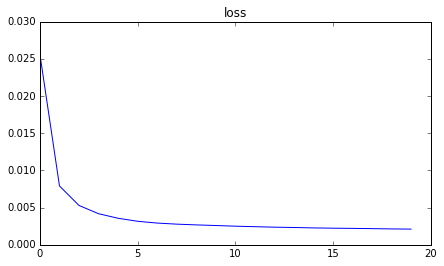

In [12]:
## lossグラフ
plt.figure(figsize=(7,4))
plt.plot(range(len(loss_arr)), loss_arr, color="#0000FF")
plt.title("loss")
plt.plot()

training image


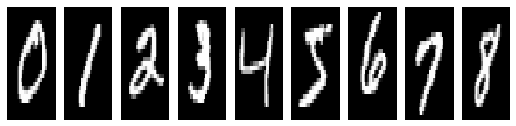

reconstruction image


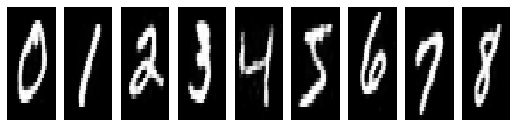

In [13]:
## 描画テスト
train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
test = chainer.Variable(xp.asarray(x_train[train_ind]), volatile='on')
y = model(test)

print "training image"
draw_digit(x_train[train_ind])

print "reconstruction image"
draw_digit(y.data.get())


## 中間層の状態を確認する

In [14]:
# 中間層の状態をプロットする
def draw_weight(data):
    # サンプラー
    n = 100
    indexes = np.random.permutation( len(data) )[:n]
    size = 28
    plt.figure(figsize=(15, 15))
    # plot
    cnt = 1
    for idx in indexes:
        plt.subplot(10, 10, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]
        plt.xlim(0, size-1)
        plt.ylim(0, size-1)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.title("{0}".format(idx), size=9)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
    return indexes

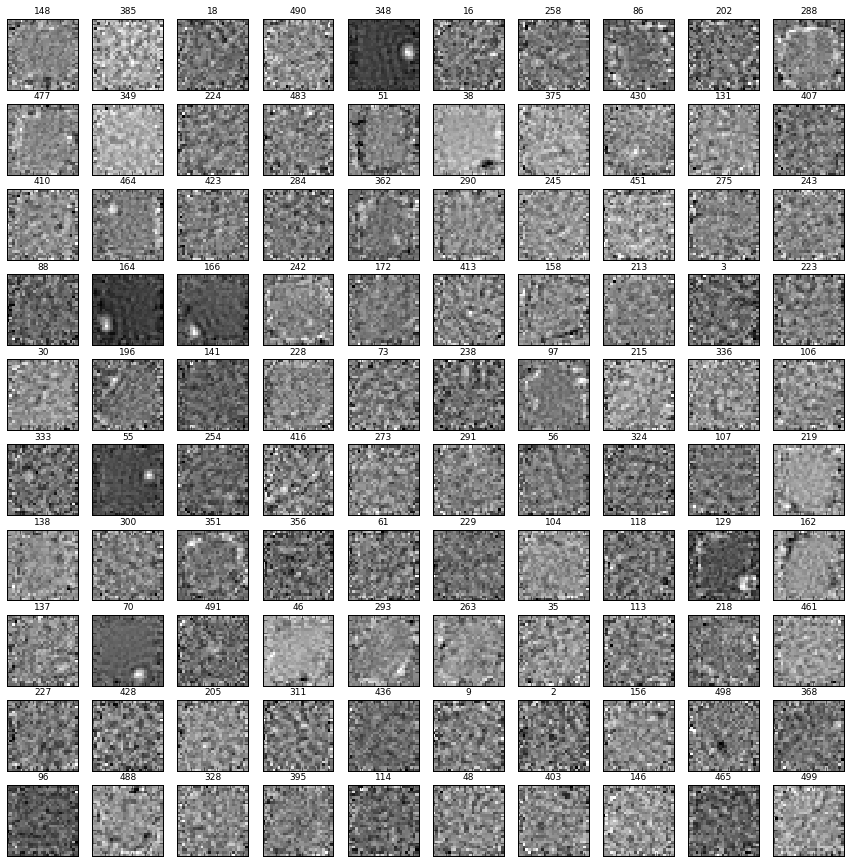

In [15]:
idxs = draw_weight(model.le1.W.data.get())

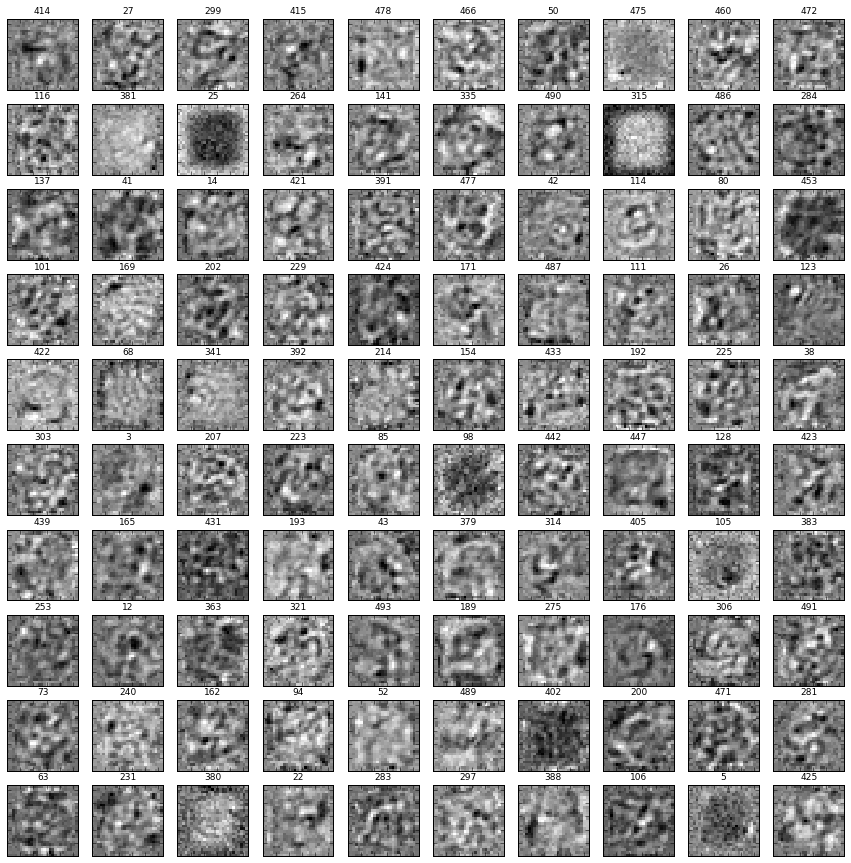

In [16]:
# 出力層の手前
idx = draw_weight(model.ld2.W.data.get().T)